In [1]:
import os
import tensorflow as tf
import numpy as np
import skimage
from skimage.transform import resize
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [4]:
def discriminator_model():

    Discriminator = tf.keras.Sequential(name='Discriminator')
    Discriminator.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding='same',                                                                                        kernel_initializer=init, input_shape=(32, 32, 3)))
    Discriminator.add(tf.keras.layers.LeakyReLU(0.2))

    Discriminator.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Discriminator.add(tf.keras.layers.LeakyReLU(0.2))

    Discriminator.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Discriminator.add(tf.keras.layers.LeakyReLU(0.2))

    Discriminator.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Discriminator.add(tf.keras.layers.LeakyReLU(0.2))

    Discriminator.add(tf.keras.layers.Flatten())
    Discriminator.add(tf.keras.layers.Dropout(0.4))
    Discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return Discriminator

In [5]:
def generator_model():

    Generator = tf.keras.Sequential(name='Generator')

    Generator.add(tf.keras.layers.Dense(units=512*2*2, input_shape=(100,), kernel_initializer=init))
    Generator.add(tf.keras.layers.Reshape((2, 2, 512)))
    Generator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Generator.add(tf.keras.layers.LeakyReLU(0.2))

    Generator.add(tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=init))
    Generator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Generator.add(tf.keras.layers.LeakyReLU(0.2))

    Generator.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=init))
    Generator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Generator.add(tf.keras.layers.LeakyReLU(0.2))

    Generator.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=init))
    Generator.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    Generator.add(tf.keras.layers.LeakyReLU(0.2))

    Generator.add(tf.keras.layers.Conv2DTranspose(filters=3, activation='tanh', kernel_size=(5, 5), strides=2, padding='same',                                                                      kernel_initializer=init))

    return Generator

In [6]:
def DCGAN_model():

    Generator = generator_model()
    Discriminator = discriminator_model()

    Discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5, beta_2=0.99), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    GANs = tf.keras.Sequential([Generator, Discriminator])
    GANs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.99), loss='binary_crossentropy', metrics=['binary_accuracy'])

    return GANs, Generator, Discriminator

In [7]:
GANs, Generator, Discriminator = DCGAN_model()

In [8]:
Generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0 

In [9]:
Discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 256)       

In [10]:
GANs.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 32, 32, 3)         4516739   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 8,825,220
Non-trainable params: 3,712
_________________________________________________________________


In [11]:
def generate_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

def generate_labels(n_samples):
    return np.ones([n_samples, 1]), np.zeros([n_samples, 1])
    
def preprocess(image):
    return (image / 255) * 2 - 1

def smooth_positive_labels(y):
    return y - 0.1 + (np.random.random(y.shape) * 0.1)

def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

In [12]:
def scale_images(images, new_shape):

    images_list = []
    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)

def calculate_fid(model, images1, images2):

    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

In [13]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [14]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [15]:
inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

In [ ]:
epochs = 3000
train_batch_size = 128
val_batch_size = 128

Y_train_real, Y_train_fake = generate_labels(train_batch_size)
Y_val_real, Y_val_fake = generate_labels(val_batch_size)

for iters in range(epochs):

    Discriminator.trainable = True

    X_batch_real = X_train[np.random.choice(X_train.shape[0], train_batch_size, replace=True), :]
    latent_samples = generate_latent_samples(train_batch_size, 100)
    X_batch_fake = Generator.predict_on_batch(latent_samples)

    Discriminator.train_on_batch(X_batch_real, smooth_positive_labels(Y_train_real))
    Discriminator.train_on_batch(X_batch_fake, smooth_negative_labels(Y_train_fake))

    Discriminator.trainable = False
    GANs.train_on_batch(latent_samples, Y_train_real)

    if (iters+1)%100 == 0:
        latent_samples = generate_latent_samples(val_batch_size, 100)
        generated_images = Generator.predict_on_batch(latent_samples)

        X_val_real = X_test[np.random.choice(X_test.shape[0], val_batch_size, replace=True), :]

        discriminator_loss_real = Discriminator.test_on_batch(X_val_real, Y_val_real)
        discriminator_loss_fake = Discriminator.test_on_batch(generated_images, Y_val_fake)
        discriminator_loss_batch = 0.5 * (round(discriminator_loss_real[0], 10) + round(discriminator_loss_fake[0], 10))

        generator_loss_batch = GANs.test_on_batch(latent_samples, Y_val_real)
        print("Epoch: {} -> DIS_LOSS_REAL: {}, DIS_LOSS_FAKE: {}, TOTAL: {}, GEN_LOSS_BATCH: {}".format(iters+1,
                                                                                            round(discriminator_loss_real[0], 10),
                                                                                            round(discriminator_loss_fake[0], 10),
                                                                                            discriminator_loss_batch,
                                                                                            round(generator_loss_batch[0], 10)))
    # if (iters+1)%1000 == 0:
    #     latent_samples = generate_latent_samples(val_batch_size, 100)
    #     generated_images = Generator.predict_on_batch(latent_samples)

    #     X_val_real = X_test[np.random.choice(X_test.shape[0], val_batch_size, replace=True), :]
    #     _, acc_real = Discriminator.evaluate(X_val_real, Y_val_real, verbose=0)
    #     _, acc_fake = Discriminator.evaluate(generated_images, Y_val_fake, verbose=0)
    #     print("Epoch: {} -> Accuracy real: {}, Accuracy fake: {}".format(iters+1,
    #                                                                     round(acc_real, 10),
    #                                                                     round(acc_fake, 10)))

    # if (iters+1)%1000 == 0:

    #     latent_samples = generate_latent_samples(1000, 100)
    #     generated_images = Generator.predict_on_batch(latent_samples)
    #     generated_images = scale_images(generated_images.astype('float32'), (299, 299, 3))

    #     X_test_batch = X_test[np.random.choice(X_test.shape[0], 1000, replace=True), :]
    #     X_test_batch = scale_images(X_test_batch.astype('float32'), (299, 299, 3))

    #     cur_fid_score = calculate_fid(inception, X_test_batch, generated_images)
    #     print("Epoch: {} -> {}".format(iters + 1, round(cur_fid_score, 5)))

In [253]:
gan_images = Generator.predict(generate_latent_samples(1, 100))

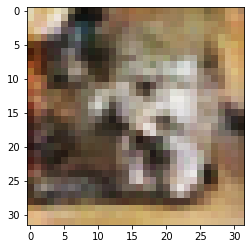

In [254]:
plt.imshow((gan_images[0]+1)/2, cmap='gray')

In [61]:
# Save the Generator model
Generator.save('./Models/best_generator')

# Save the Discriminator model
Discriminator.save('./Models/best_discriminator')

# Save the GAN model
GANs.save('./Models/best_GAN')

INFO:tensorflow:Assets written to: ./Models/best_generator\assets
INFO:tensorflow:Assets written to: ./Models/best_discriminator\assets
INFO:tensorflow:Assets written to: ./Models/best_GAN\assets


In [258]:
Generator = tf.keras.models.load_model('./Models/best_generator')
# Discriminator = tf.keras.models.load_model('./Models/best_discriminator')
# GANs = tf.keras.models.load_model('./Models/best_GAN')

In [270]:
def plot_final_grid(generated_images):

    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(64):
        ax = fig.add_subplot(8, 8, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.show()

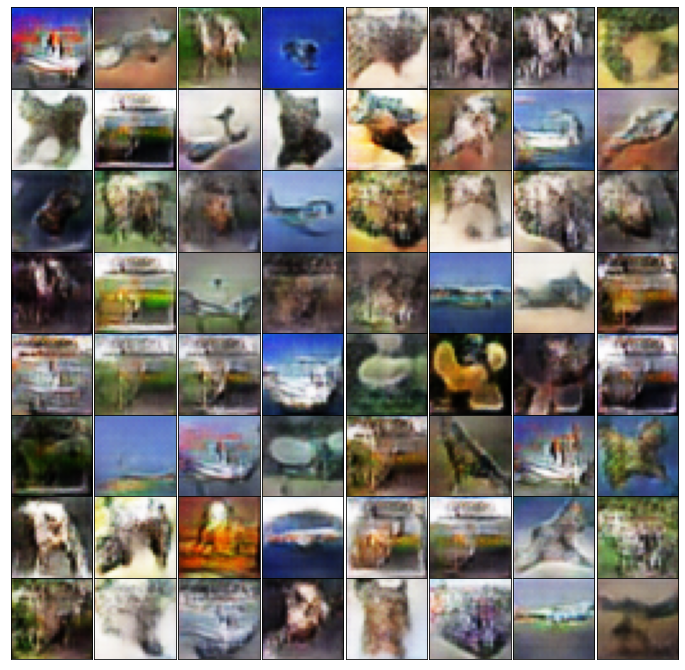

In [273]:
gan_images = Generator.predict(generate_latent_samples(64, 100))
plot_final_grid(gan_images)